In [1]:
import numpyro as npy
import jax.numpy as jnp
import jax.random as random
import numpy as np
import plotly.express as px
import plotly.io as pio
import arviz as az

In [2]:
pio.renderers.default = "svg"

# Modeling in NumPyro

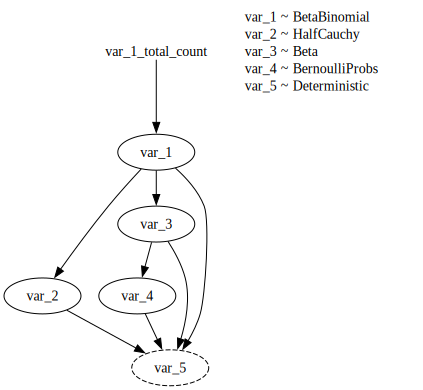

In [39]:
def model():
    var_1_total_count = npy.param(
        name="var_1_total_count",
        init_value=30
    )

    var_1 = npy.sample(
        name="var_1",
        fn=npy.distributions.BetaBinomial(
            concentration1=0.5,
            concentration0=0.5,
            total_count=var_1_total_count
        )
    )

    var_2 = npy.sample(
        name="var_2",
        fn=npy.distributions.HalfCauchy(
            scale=var_1
        )
    )

    var_3 = npy.sample(
        name="var_3",
        fn=npy.distributions.Beta(
            concentration0=var_1,
            concentration1=2
        )
    )

    var_4 = npy.sample(
        name="var_4",
        fn=npy.distributions.Bernoulli(
            probs=var_3
        )
    )

    var_5 = npy.deterministic(
        name="var_5",
        value=jnp.where(
            var_1 > 20,
            (var_1 + var_2 * var_3 * var_4)**2,
            var_1 + var_2 * var_3 * var_4
        )
    )

    return None

npy.render_model(
    model=model,
    render_distributions=True,
    render_params=True
)

In [40]:
hmc_kernel = npy.infer.HMC(model=model)

mixed_hmc = npy.infer.MixedHMC(
    inner_kernel=hmc_kernel   
)

mcmc = npy.infer.MCMC(
    sampler=mixed_hmc,
    num_warmup=100,
    num_samples=100,
    num_chains=4
)

# Run the MCMC sampler and collect samples
mcmc.run(
    rng_key=random.PRNGKey(seed=42)
)

/tmp/ipykernel_76070/3617518464.py:7: UserWarning:

There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.

sample: 100%|██████████| 200/200 [00:00<00:00, 2476.48it/s, 17 steps of size 4.08e-01. acc. prob=0.96]


In [41]:
model_samples = mcmc.get_samples()

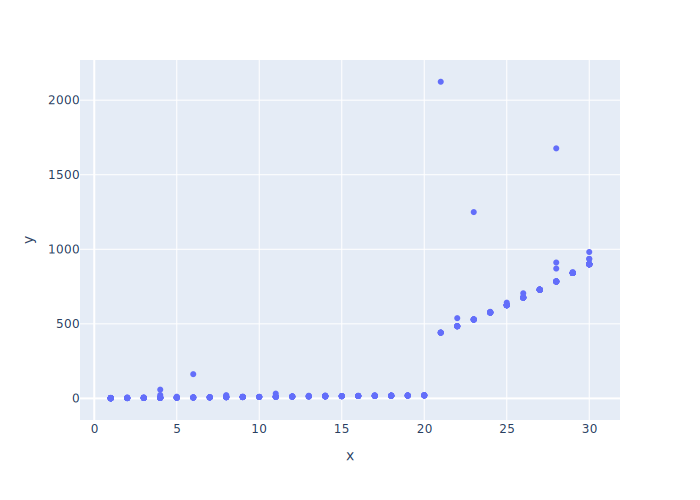

In [42]:
px.scatter(
    x=model_samples["var_1"],
    y=model_samples["var_5"]
)

array([[<Axes: title={'center': 'var_1'}>,
        <Axes: title={'center': 'var_2'}>,
        <Axes: title={'center': 'var_3'}>],
       [<Axes: title={'center': 'var_4'}>,
        <Axes: title={'center': 'var_5'}>, <Axes: >]], dtype=object)

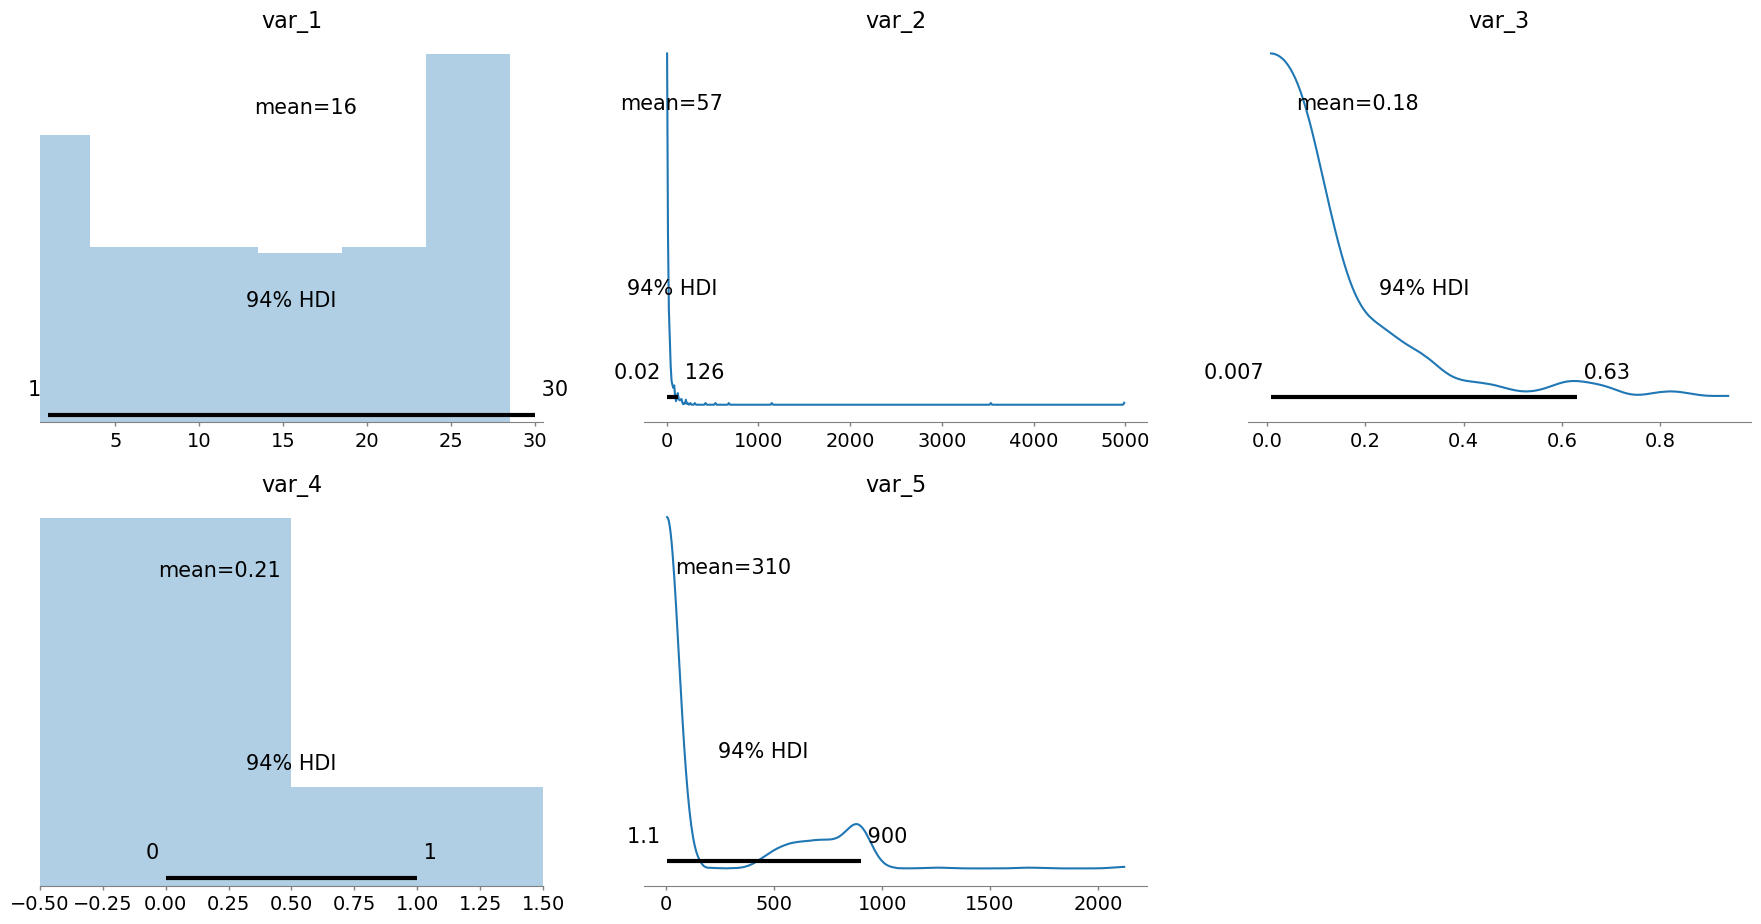

In [48]:
az_model = az.from_numpyro(posterior=mcmc)
az.plot_posterior(az_model.posterior)

# Sample from Distribution

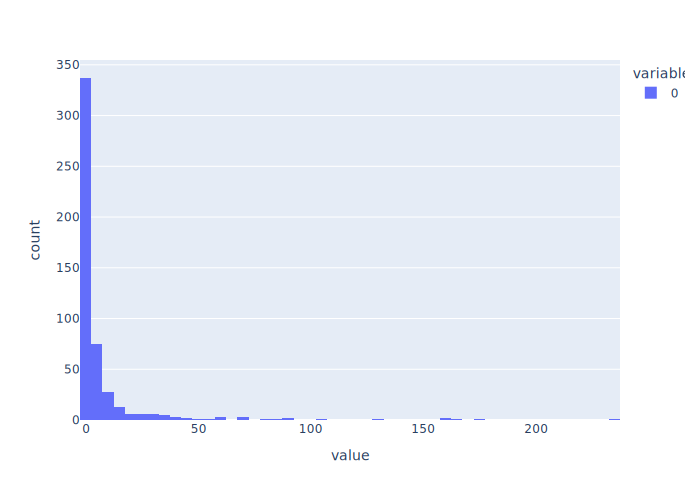

In [32]:
y = npy.distributions.LogNormal(0, 2).sample(random.PRNGKey(seed=42), (500,))
px.histogram(y)

# Timeseries

In [17]:
# https://num.pyro.ai/en/stable/examples/gp.html
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


In [84]:
# https://realpython.com/python-super/#an-overview-of-pythons-super-function
class Pert(npy.distributions.Beta):
    """Class for modified-PERT distribution from numpyro
    with parameters
    a: min
    b: mode
    c: max
    gamma: Lower values of gamma make for a
        distribution that is less peaked 
        at the mode.
        gamma > 0
    """
    def __init__(self, a, b, c, gamma=4):
        # https://pubsonline.informs.org/doi/epdf/10.1287/ited.1080.0013
        # Davis 2008 formula for conversion
        # between PERT and beta distributions
        # https://en.wikipedia.org/wiki/PERT_distribution#The_modified-PERT_distribution
        mu = (a + gamma * b + c)/(gamma + 2)
        # https://reference.wolfram.com/language/ref/PERTDistribution.html
        sigma_squared = (c - a - b*gamma + c*gamma)*(c + b*gamma - a * (1 + gamma))/((2 + gamma)**2 * (3 + gamma))
        alpha_plus_beta = (mu - a)*(c - mu)/sigma_squared - 1 
        alpha = (mu - a)/(c - a)*alpha_plus_beta
        beta = (c - mu)/(c - a)*alpha_plus_beta
        concentration1 = alpha
        concentration0 = beta
        super().__init__(concentration1, concentration0)
        


In [144]:
def model_2(times, means_a, means_b, means_c, means_gamma, var, noise, length):
    # compute kernel
    k = kernel(times, times, var, length, noise)

    # means = npy.sample(
    #     name="means",
    #     fn=Pert(a=means_a, b=means_b, c=means_c, gamma=means_gamma)
    # )
    means = 0.9*np.ones(shape=times.shape)

    # sample Y according to the standard gaussian process formula
    Y = npy.sample(
        name="Y",
        fn=npy.distributions.MultivariateNormal(
            loc=means, 
            covariance_matrix=k
        )
    )
    
    Y_2 = npy.deterministic(
        name="Y_2",
        value=jnp.where(
            Y < 0,
            jnp.zeros(shape=Y.shape),
            Y
        )
    )

    Z = npy.deterministic(
        name="Z",
        value=jnp.where(
            Y_2 > 1,
            jnp.ones(shape=Y.shape),
            Y_2
        )
    )

    return Z

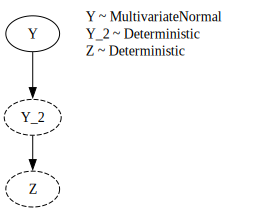

In [145]:
model_2_kwargs={
    "times": np.arange(1800), 
    "means_a": 0,
    "means_b": 0.4,
    "means_c": 1,
    "means_gamma": 100,
    "var": 0.1,
    "noise": 0,
    "length": 14
}

npy.render_model(
    model=model_2,
    model_kwargs=model_2_kwargs,
    render_distributions=True,
    render_params=True
)

In [146]:
nuts_kernel_2 = npy.infer.NUTS(model=model_2)

mcmc_2 = npy.infer.MCMC(
    sampler=nuts_kernel_2,
    num_warmup=100,
    num_samples=2,
    num_chains=1
)

# Run the MCMC sampler and collect samples
mcmc_2.run(
    rng_key=random.PRNGKey(seed=42),
    **model_2_kwargs
)

sample: 100%|██████████| 102/102 [00:49<00:00,  2.06it/s, 1023 steps of size 1.60e-03. acc. prob=0.96]


In [147]:
model_2_samples = mcmc_2.get_samples()

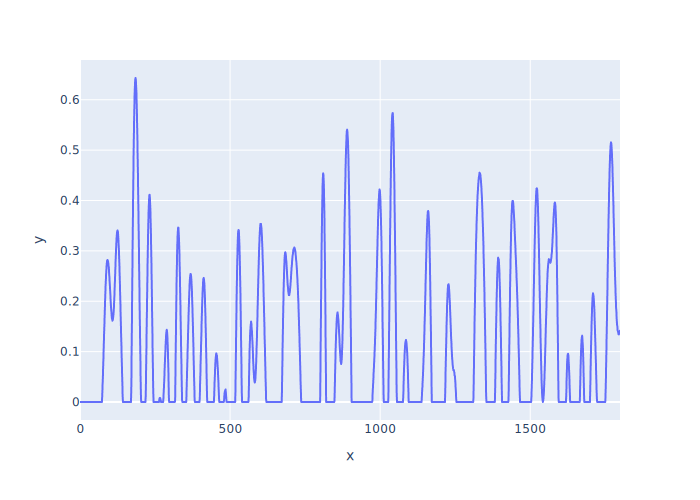

In [149]:
px.line(
    x=np.arange(1800),
    y=model_2_samples["Z"][1, :]
)